# Programming Assignment I: Exploratory Analysis over 2012 FEC Presidential Election Dataset

In [21]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

#Array processing
import numpy as np
#Data analysis, wrangling and common exploratory operations
import pandas as pd
from pandas import Series, DataFrame

#A sane way to get web data
import requests

#Packages for web scraping. No need to use both. Feel free to use one of them.
from pattern import web
from BeautifulSoup import BeautifulSoup

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.
import matplotlib.pyplot as plt
import seaborn as sns

#For some of the date operations
import datetime


pd.set_option('display.notebook_repr_html',True)
from IPython.display import display

Part 1: Web Scraping
----------------

In the first series of tasks, we will seek to scrape information from diverse websites. To make your job easier, you can assume that you do not need to do any complex webdriver stuff. For each task, you will implement a function that accepts an url and produces output in the format that the question asks.

NOTE: Make sure that you follow the input and output requirements. The assignment will be evaluated and graded automatically by a script. Any error will result in you getting a score of 0 for that task.


(5 points) Website 1: Wikipedia
-----------------------

In the first task, we will seek to parse contents from a table in a Wikipedia page. You will implement a function that accepts two parameters. The first is the url and the second is the name of the table. For example, if the url was http://en.wikipedia.org/wiki/List_of_Test_cricket_records and the table name was "Team wins, losses and draws", then you have to parse the first table. Your code must produce as an output a Pandas data frame where the columns have same name as the table ('Team',	'First Test match',	'Matches',	'Won',	'Lost',	'Tied',	'Drawn' and '% Won') in this example. 

Do NOT worry about the data format of the Pandas data frame. Simply treat each of them as a string.



In [22]:
#Input:
#    url: URL of a wikipedia page
#    table_id: Index of the table to scrape
#Output:
#    df is a Pandas data frame that contains a tabular representation of the table
#    The columns are named the same as the table columns
#    Each row of df corresponds to a row in the table
def scraping_wikipedia_table(url, table_id):
    website_html = requests.get(url).text
    dom = web.Element(website_html)
    tbls = [t for t in dom.by_tag('table')]
    tbl = tbls[table_id-1]  #correct the off by one error
    headerRow = tbl.by_tag("tr")[0] #simple trick - first row always gives the header
    #the title could be inside a th tag or td tag
    # use the in operator to determine which is the case and use the right filtering
    if len(headerRow.by_tag("th")) > 0:
        heading = [web.plaintext(th.content) for th in headerRow.by_tag('th')]
    else:
        heading = [web.plaintext(td.content) for td in headerRow.by_tag('td')]

    #DataFrame has many constructors. On a whim I am choosing the list of dicts
    arrayOfDict = [] 
    for row in tbl.by_tag("tr")[1:-1] : #ignore the last row about updated date 
        thContents = [web.plaintext(td.html) for td in row.by_tag("th")]
        tdContents = [web.plaintext(td.html) for td in row.by_tag("td")]
        contents = thContents + tdContents #big time hack - assumes th, if present is always the first column
        #Convert contents to a dictionary with appropriate headings
        rowAsDict = {heading[i] : contents[i] for i in range(len(contents))}
        arrayOfDict.append(rowAsDict)
    df = DataFrame(arrayOfDict,columns=heading)
    return df

print display(scraping_wikipedia_table("http://en.wikipedia.org/wiki/List_of_Test_cricket_records", 1))

Team                  First Test match Matches  Won Lost Tied  \
0      Australia     01877-03-15-000015 March 1877     773  362  205    2   
1     Bangladesh  02000-11-10-000010 November 2000      88    7   70    0   
2        England     01877-03-15-000015 March 1877     952  339  275    0   
3          India      01932-06-25-000025 June 1932     487  122  156    1   
4    New Zealand   01930-01-10-000010 January 1930     399   80  160    0   
5       Pakistan   01952-10-16-000016 October 1952     387  121  110    0   
6   South Africa     01889-03-12-000012 March 1889     390  144  129    0   
7      Sri Lanka  01982-02-17-000017 February 1982     235   71   84    0   
8    West Indies      01928-06-23-000023 June 1928     503  163  170    1   
9       Zimbabwe   01992-10-18-000018 October 1992      97   11   60    0   
10  ICC World XI   02005-10-14-000014 October 2005       1    0    1    0   

   Drawn  % Won  
0    204  46.83  
1     11   7.95  
2    338  35.60  
3    208  25.05  
4    159  20.05  
5    156  31.26  
6    117  36.92  
7     80  30.21  
8    169  32.40  
9     26  11.34  
10     0   0.00

None



### (5 points)  Website 2: Walmart

In the second task, we will seek to scrape the results of Walmart. Specifically, we will focus on Movies department. Your job is to implement a function that accepts a valid search result url  (such as http://www.walmart.com/search/?query=marvel&cat_id=4096_530598 ), scrapes the 10-15 product listings in that url only and outputs a Pandas data frame with the following fields (with the EXACT names and data types as below): 

+ Product Title: String. Title of the product (such as Samsung Red WB1100F Smart Camera with 16.2 Megapixels and 35x Optical Zoom)
+ Sale Price: Float. Price of the product (such as 249.99). This is the price that is highlighted in blue typically. Ignore the dollar sign and return the value only
+ Number of Ratings: Integer. The number of ratings that users have provided for the product. This is the number associated with the star.
+ Free Shipping: Boolean. Is True if the product has free shipping above $50 and false otherwise. 
+ Free Store Pickup: Boolean. Is True if the product has free store pickup and false otherwise. 
+ Starring: String. Contains the name of starring actors. Convert it to a simple string such as "Chris Pratt Zoe Saldana Vin Diesel" is okay. No need to parse it further.
+ Running: Integer. The running time of the movie. Only the integer value is required (ie. NNNN minutes then return only NNNN).
+ Format: String. Values such as Widescreen. Beware, some entries might not have this value.
+ Rating: String. MPAA rating.

Make sure that you observe the following:

* If a data type is specified, then your data should be in that format. For eg, if a field is int, then ensure that it has an integer value.
* Your code should not crash if some product did not have a valid value such as price. Instead you must fill it with NA (see Pandas tutorial for what NA is). 

In [23]:
#Input:
#    url: URL of a Walmart results page for a search query in Movies department
#Output:
#    df is a Pandas data frame that contains a tabular representation of the results
#    The df must have 9 columns that must have the same name and data type as described above
#    Each row of df corresponds to a movie in the results table

def getValuesSafely(domObj, domSearchString):
    results = domObj(domSearchString)
    if len(results) > 0:
        return web.plaintext(results[0].content)
    else:
        return np.nan
    
def scraping_walmart_movies(url):
    website_html = requests.get(url).text
    dom = web.Element(website_html)
    heading = ['Product Title', 'Sale Price', 'Number of Ratings', 'Free Shipping', 'Free Store Pickup', 
                'Starring', 'Running', 'Format', 'Rating']

    arrayOfDict = []

    movies = dom("div.js-tile.tile-landscape")
    for movie in movies:
        productTitle = getValuesSafely(movie, 'h4 > a')
        salesPrice = getValuesSafely(movie, 'div.item-price-container > span.price.price-display')
        numRatings = getValuesSafely(movie,'span.stars-reviews')
        freeShipping = "shipping on orders over $50" in movie #Horrible hack
        freeStorePickup = "store pickup" in movie #Horrible Hack
        dl = movie('dl.media-details.dl-horizontal')
        dt = dl[0].by_tag("dt")
        dd = dl[0].by_tag("dd")

        tempOrder = ["Director:", "Starring:", "Running:", "Format:", "Release:", "Rating:"]
        tempDict = {key : np.nan for key in tempOrder} 
        index = 0
        for key in tempOrder:
            if key in movie:
                tempDict[key] = web.plaintext(dd[index].content)
                index = index + 1
                
        movieAsDict = {'Product Title': productTitle, 'Sale Price': salesPrice, 'Number of Ratings': numRatings, 
                       'Free Shipping':freeShipping,  'Free Store Pickup':freeStorePickup, 
                       'Starring': tempDict["Starring:"], 'Running': tempDict["Running:"], 
                       'Format': tempDict["Format:"], 'Rating': tempDict["Rating:"]}
        arrayOfDict.append(movieAsDict)
        

    df = DataFrame(arrayOfDict,columns=heading)
    return df 

print display(scraping_walmart_movies('http://www.walmart.com/search/?query=marvel&cat_id=4096_530598'))

Product Title Sale Price  \
0                           Marvel Heroes: Collection     $33.98   
1                  Marvel's The Avengers (Widescreen)     $19.96   
2        Marvel: Guardians Of The Galaxy (Widescreen)     $19.96   
3   Marvel Knights: Wolverine Versus Sabretooth - ...     $13.47   
4   Marvel's The Avengers (DVD + Blu-ray) (Widescr...     $29.96   
5                Marvel Complete Giftset (Widescreen)     $26.96   
6   Elektra / Fantastic Four / Daredevil (Director...     $13.99   
7            The Punisher (Extended Cut) (Widescreen)      $7.00   
8                           Spider-Man 2 (Widescreen)     $12.96   
9   Superheroes Collection: The Incredible Hulk Re...     $13.47   
10  Marvel: Iron Man & Hulk - Heroes United (Wides...     $19.96   
11   Captain America: The Winter Soldier (Widescreen)     $19.96   
12       Iron Man 3 (DVD + Digital Copy) (Widescreen)     $19.96   
13                  Thor: The Dark World (Widescreen)     $19.96   
14  Spider-Man (2-Disc) (Special Edition) (Widescr...     $12.96   
15  Spider-Man / Spider-Man 2 / Spider-Man 3 (Wide...     $25.46   
16  DC Showcase: Superman / Shazam!: The Return Of...      $9.07   
17  The Next Avengers: Heroes Of Tomorrow (Widescr...      $5.00   
18    Ultimate Avengers Movie Collection (Widescreen)     $11.17   
19          Ultimate Avengers: The Movie (Widescreen)      $5.39   

   Number of Ratings Free Shipping Free Store Pickup  \
0       (1)\nratings          True              True   
1      (68)\nratings          True              True   
2      (44)\nratings          True              True   
3                NaN         False             False   
4       (5)\nratings          True              True   
5                NaN          True              True   
6                NaN          True              True   
7       (4)\nratings          True              True   
8       (3)\nratings          True              True   
9                NaN          True              True   
10      (1)\nratings          True              True   
11     (19)\nratings          True              True   
12     (26)\nratings          True              True   
13     (22)\nratings          True              True   
14     (11)\nratings          True              True   
15               NaN         False              True   
16     (10)\nratings          True              True   
17      (9)\nratings          True              True   
18      (5)\nratings          True              True   
19      (7)\nratings          True              True   

                                             Starring      Running  \
0   * Rebecca Romijn\n* Hugh Jackman\n* Chris Evan...  856 minutes   
1   * Robert Downey Jr.\n* Chris Evans\n* Mark Ruf...  145 minutes   
2   * Chris Pratt\n* Zoe Saldana\n* Vin Diesel\n* ...  121 minutes   
3                       * Jeph Loeb\n* Simone Bianchi   44 minutes   
4   * Robert Downey Jr.\n* Chris Evans\n* Mark Ruf...  145 minutes   
5   * Justin Gross\n* Grey Delisle\n* Michael Mass...  640 minutes   
6   * Jessica Alba\n* Chris Evans\n* Jennifer Garn...          NaN   
7   * John Travolta\n* Thomas Jane\n* Ben Foster\n...  140 minutes   
8   * Tobey Maguire\n* Kirsten Dunst\n* James Fran...  128 minutes   
9   * Bill Bixby\n* Jack Colvin\n* Lou Ferrigno\n*...  247 minutes   
10   * Adrian Pasdar\n* Fred Tatasciore\n* David Kaye   72 minutes   
11  * Chris Evans\n* Scarlett Johansson\n* Anthony...  136 minutes   
12  * Robert Downey Jr.\n* Gwyneth Paltrow\n* Don ...  135 minutes   
13  * Chris Hemsworth\n* Natalie Portman\n* Tom Hi...  112 minutes   
14  * Tobey Maguire\n* Willem Dafoe\n* Kirsten Dun...  121 minutes   
15  * Tobey Maguire\n* Kirsten Dunst\n* James Fran...  523 minutes   
16                                                NaN   63 minutes   
17  * Noah Crawford\n* Nicole Oliver\n* Shawn MacD...   78 minutes   
18                                                NaN  222 minutes   
19  * Justin Gross\n* Grey DeLisle

None


### (2.5 * 4 = 10 points) Website 3: Facebook

In the third task, we will scrape some specific sub-pages of Facebook profiles. In order to avoid using sophisticated tools like Selenium, for this task you can assume that the input to the function is the DOM of the relevant page. You can then use it to parse relevant contents.

In [24]:
#Input: dom - DOM of the books page corresponding to an FB account's profile. Eg, DOM of https://www.facebook.com/zuck/books
#Output: An array (Python list) of books listed in the profile page. 
#    Note that this function requires a list as an output not a Pandas data frame
def scraping_facebook_books(dom):
      return [li("a._gx7")[0].title for li in dom("ul.uiList > li")]
    
#Input: dom - DOM of the groups page corresponding to an FB account's profile. Eg, DOM of https://www.facebook.com/zuck/groups
#Output: A Pandas data frame with one row per group. 
#    It must have three columns - 'Group Name', 'Number of Members', 'Group Description'
#    Note that all information of a group is in the same page (eg. https://www.facebook.com/zuck/groups)
#    You can collect all data from same page even if they are incomplete (such as group description)
#    Ensure that the column names as given above
def scraping_facebook_groups(dom):
    arrayOfDict = []
    for li in dom("ul.uiList > li"):
        groupAsDict = {}
        groupAsDict["Group Name"] = web.plaintext(li("div.mbs.fwb")[0].content)
        groupAsDict["Number of Members"] = web.plaintext(li("div.mbs.fcg")[0].content)
        groupAsDict["Group Description"] = web.plaintext(li("div.mtm > span")[0].content)
        arrayOfDict.append(groupAsDict)
    df = DataFrame(arrayOfDict,columns=["Group Name", "Number of Members", "Group Description"])
    return df

#Input: dom - DOM of the music page corresponding to an FB account's profile. Eg, DOM of https://www.facebook.com/zuck/music
#Output: A Pandas data frame with one row per group. 
#    It must have four columns 
#    'Name', 'Type' (eg. Musician/Band or Bands&Musicians) and 'Verified' (boolean: True/False), 'Profile Url'
#    Note that all information of a group is in the same page (eg. https://www.facebook.com/zuck/music)
#    Ensure that the column names as given above
def scraping_facebook_music(dom):
    arrayOfDict = []
    for li in dom("ul.uiList > li"):
        musicAsDict = {}
        musicAsDict["Name"] = li("a._gx7")[0].title
        musicAsDict["Type"] = web.plaintext(li("div.fsm.fwn.fcg")[0].content)
        musicAsDict["Verified"] = "Verified Page" in li
        musicAsDict["Profile Url"] =  li("a._gx7")[0].href
        arrayOfDict.append(musicAsDict)
    df = DataFrame(arrayOfDict,columns=["Name", "Type", "Verified", "Profile Url"])
    return df

#Input: dom - DOM of the music page corresponding to an FB account's profile. Eg, DOM of https://www.facebook.com/zuck/movies
#Output: A Pandas data frame with one row per group. 
#    It must have following columns - 
#        'Name', 'Type' (eg. Movie), 'Verified', 'Profile Url' - as before
#    Ensure that the column names as given above
def scraping_facebook_movies(dom):
    arrayOfDict = []
    for li in dom("ul.uiList > li"):
        movieAsDict = {}
        movieAsDict["Name"] = li("a._gx7")[0].title
        movieAsDict["Type"] = web.plaintext(li("div.fsm.fwn.fcg")[0].content)
        movieAsDict["Verified"] = "Verified Page" in li
        movieAsDict["Profile Url"] =  li("a._gx7")[0].href
        arrayOfDict.append(movieAsDict)
    df = DataFrame(arrayOfDict,columns=["Name", "Type", "Verified", "Profile Url"])
    return df

books_html = open("zuckBooks.html").read()
#Uncomment one of these lines based on whether you used Pattern or BeautifulSoup
dom = web.Element(books_html)
#dom = BeautifulSoup(books_html)
print "Books in Zuck's FB:\n", scraping_facebook_books(dom)

group_html = open("zuckGroups.html").read()
dom = web.Element(group_html)
#dom = BeautifulSoup(group_html)
print "\n\nGroups in Zuck's FB:\n"
display(scraping_facebook_groups(dom))


music_html = open("zuckMusic.html").read()
dom = web.Element(music_html)
#dom = BeautifulSoup(music_html)
print "\n\nMusic in Zuck's FB:\n"
display(scraping_facebook_music(dom))


movies_html = open("zuckMovies.html").read()
dom = web.Element(movies_html)
#dom = BeautifulSoup(movies_html)
print "\n\nMovies in Zuck's FB:\n"
display(scraping_facebook_movies(dom))

Books in Zuck's FB:
[u'Gang Leader for a Day: A Rogue Sociologist Takes to the Streets', u'The Better Angels of Our Nature', u'American Lion: Andrew Jackson in the White House', u"The House of Rothschild: Volume 1: Money's Prophets: 1798-1848", u'Open: An Autobiography', u'The Information: A History, a Theory, a Flood', u"Surely You're Joking, Mr. Feynman!", u'The Idea Factory: Bell Labs and the Great Age of American Innovation', u'Decoded', u'Einstein: His Life and Universe', u'Physics of the Impossible', u"Ender's Shadow", u'The Giving Tree', u"Ender's Game"]


Groups in Zuck's FB:



Group Name Number of Members  \
0      Pulis        30 members   

                                   Group Description  
0  This is a group for our favorite Hungarian bre...



Music in Zuck's FB:



Name           Type Verified  \
0            Imagine Dragons  Musician/Band     True   
1                    Beyoncé  Musician/Band     True   
2                    Rihanna         Artist     True   
3   The All-American Rejects  Musician/Band     True   
4            LCD Soundsystem  Musician/Band     True   
5                  Daft Punk  Musician/Band     True   
6                Linkin Park  Musician/Band     True   
7          Ingrid Michaelson  Musician/Band     True   
8                  Radiohead  Musician/Band     True   
9                    Shakira  Musician/Band     True   
10                   Nirvana  Musician/Band     True   
11                     JAY Z  Musician/Band     True   
12               The Killers  Musician/Band     True   
13                 Green Day  Musician/Band     True   
14              Taylor Swift  Musician/Band     True   
15                 Lady Gaga  Musician/Band     True   
16                Katy Perry  Musician/Band     True   
17                        U2  Musician/Band     True   
18                John Mayer  Musician/Band     True   

                                          Profile Url  
0   https://www.facebook.com/ImagineDragons?ref=pr...  
1        https://www.facebook.com/beyonce?ref=profile  
2        https://www.facebook.com/rihanna?ref=profile  
3   https://www.facebook.com/AllAmericanRejects?re...  
4   https://www.facebook.com/lcdsoundsystem?ref=pr...  
5       https://www.facebook.com/daftpunk?ref=profile  
6     https://www.facebook.com/linkinPark?ref=profile  
7   https://www.facebook.com/ingridmichaelson?ref=...  
8      https://www.facebook.com/radiohead?ref=profile  
9        https://www.facebook.com/shakira?ref=profile  
10       https://www.facebook.com/Nirvana?ref=profile  
11          https://www.facebook.com/JayZ?ref=profile  
12    https://www.facebook.com/Thekillers?ref=profile  
13      https://www.facebook.com/GreenDay?ref=profile  
14   https://www.facebook.com/TaylorSwift?ref=profile  
15      https://www.facebook.com/ladygaga?ref=profile  
16     https://www.facebook.com/katyperry?ref=profile  
17            https://www.facebook.com/u2?ref=profile  
18     https://www.facebook.com/johnmayer?ref=profile



Movies in Zuck's FB:



Name     Type Verified  \
0                      Hero    Movie     True   
1          Django Unchained    Movie     True   
2                 MoneyBall    Movie     True   
3                 Gladiator    Movie     True   
4                The Matrix    Movie     True   
5                 Star Wars    Movie     True   
6   Batman: The Dark Knight    Movie     True   
7    Waiting for "Superman"    Movie     True   
8                  Iron Man    Movie     True   
9                  Fearless    Movie    False   
10            The Godfather    Movie     True   
11             Disney Pixar  Company     True   

                                          Profile Url  
0      https://www.facebook.com/HeroMovie?ref=profile  
1   https://www.facebook.com/unchainedmovie?ref=pr...  
2   https://www.facebook.com/MoneyballMovie?ref=pr...  
3   https://www.facebook.com/gladiatormovie?ref=pr...  
4   https://www.facebook.com/TheMatrixMovie?ref=pr...  
5       https://www.facebook.com/StarWars?ref=profile  
6     https://www.facebook.com/darkknight?ref=profile  
7   https://www.facebook.com/waitingforsuperman?re...  
8        https://www.facebook.com/ironman?ref=profile  
9   https://www.facebook.com/pages/Fearless/112430...  
10  https://www.facebook.com/thegodfather?ref=profile  
11   https://www.facebook.com/DisneyPixar?ref=profile

Part 2 and 3: Exploratory Analysis and Visualization
======================

Data Set Description
---------------------

In this assignment, you will use the FEC dataset. The US Federal Election Commission publishes data on contributions to political campaigns. This includes contributor names, occupation and employer, address, and contribution amount. Specifically, we will be using the FEC data from 2012 election between Barack Obama and Mitt Romney. This is widely considered as a landmark election as both sides spent an unprecedented amount of 1 Billion dollars each (i.e. more than 6000 Crores in INR each). If you are interested, you can download the entire list of contributor details at the [FEC site](http://www.fec.gov/disclosurep/PDownload.do). It is relatively large (150 MB compressed, 1 GB uncompressed). For our experiments, we will use a smaller subset of the data collected (and cleaned) by Wes McKinney (the creator of Pandas). For the download link, see the [Assignments page](http://saravanan-thirumuruganathan.github.io/cse5334Spring2015/assignments.html). It is small by most standards (around 1.4 million records, 20 MB compressed, 160 MB uncompressed) but large enough to give a taste of why data mining is compute intensive. Hopefully, this will also give you an appreciation as to the awesomeness of Pandas/Numpy - you can do really cool stuff with 2-3 lines of code that runs in seconds. 

**Dataset Description:** You can find the details (such as meaning of the column names) of the dataset in the [FEC website](ftp://ftp.fec.gov/FEC/Presidential_Map/2012/DATA_DICTIONARIES/CONTRIBUTOR_FORMAT.txt).

While a knowledge of US Elections or FEC Campaign finance rules is not necessary for solving this assignment, you can check out the following links if you are curious. 

[How to Become the US President: A Step-by-Step Guide](http://2012election.procon.org/view.resource.php?resourceID=004333)

[US Election guide: how does the election work?](http://www.telegraph.co.uk/news/worldnews/us-election/9480396/US-Election-guide-how-does-the-election-work.html)

If you are fascinated with Campaign finance reform (as I am), here are some good links:

[Super-PACs and Dark Money: ProPublica’s Guide to the New World of Campaign Finance](http://www.propublica.org/blog/item/super-pacs-propublicas-guide-to-the-new-world-of-campaign-finance)

[40 charts that explain money in politics](http://www.vox.com/2014/7/30/5949581/money-in-politics-charts-explain)

Visualization
-------------

Visualization is a key component of exploration. You will perform a number of 1-D and 2-D charts to get some intuition about the data. You can choose to use either Matplotlib or Seaborn for plotting. The default figures generated from Matplotlib might look a bit ugly. So you might want to try Seaborn to get better figures. The defaults in Seaborn are much saner and sometimes makes your life lot easier. Seaborn has number of styles - so feel free to experiment with them and choose the one you like. We have earmarked 10 points for the aesthetics of your visualizations.  

Pandas
----------
Almost all the tasks below could be purely solved using Pandas. Most analytic tasks should not require more than 2-3 lines of code (visualization on the other hand is a different matter - you might need 5-10 lines for each chart unless you use Seaborn). Here is a NON COMPREHENSIVE list of functions that you might want to know to solve this assignment : agg, apply, argmax, argmin, count, crosstab, cumsum, cut, describe, groupby, head, idxmax, idxmin, info, isin, map, max, min, pivot_table, size, sum, transform, unique, value_counts .



Exploration Tasks
==================

You can find a set of exploratory analytics tasks below. Ensure that you clearly follow the instructions. The assignment will be graded automatically - so failure to follow might cause some issues. Also do NOT rename the functions or variables that the instructor has set. Of course, feel free to create new variables/functions that will hep your code. 

Reading and Filtering Dataset
------------------------------
The FEC data contains information about all presidential candidates. As a sitting president, Barack Obama was the only candidate from the Democratic party. In the Republican party, there was a process called Primary (see links above) where number of candidates competed to be the nominee. Mitt Romney won the Republican primary and competed with Barack Obama in the elections, which Obama won. 

The Python code below reads the FEC dataset into a Pandas data frame with the name fec_all. If your machine has less than 2 GB of RAM, then change the function argument low_memory to True. Once the frame is loaded, we remove all negative contributions (where the campaign refunded amount to a contributor for some reason). Finally, we create a new data frame called fec that contains the contributions to Barack Obama and Mitt Romney alone. 

For this code to work, the file 'fec_2012_contribution_subset.csv' must be in the same folder as the notebook. 

To reduce my typing, I might refer to Obama as BO and Romney as MR in the text below.

In [25]:
#read the csv file into a Pandas data frame
fec_all = pd.read_csv('fec_2012_contribution_subset.csv', low_memory=False)

#We will be doing party wise analysis later. So, we want to associate each candidate with their party
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

#create a new column called party that sets the value to the party of the candidate
# The way this line works is as follows:
#  1. fec_all.cand_nm gives a vector (or Series in Pandas terminology)
#  2. For each row, the code looks up the candidate name to the dictionary parties
#  3. If the name of the candidate (cand_nm) is in parties, it returns the value (i.e. Republican or Democrat)
#  4. This whole thing is done for each row and you get another vector as output
#  5. Finally, you create a new column in fec_all called 'party' and assign the vector you got to it.
#  6. All in a single line :)
fec_all['party'] = fec_all.cand_nm.map(parties)

#ignore the refunds
# Get the subset of dataset where contribution amount is positive
fec_all = fec_all[fec_all.contb_receipt_amt > 0]

#fec_all contains details about all presidential candidates. 
#fec contains the details about contributions to Barack Obama and Mitt Romney only
#for the rest of the tasks, unless explicitly specified, work on the fec data frame.
fec = fec_all[fec_all.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]



Task 1: Descriptive Statistics
--------------------------------

Let us start with some easy stuff. As of now, you do not know anything about the dataset. So the first task will be to get some basic sense. 

 

In [26]:
#Task 1a: print the details of the data frame. 
# Basically, this should contain information such as number of rows,columns, name of columns, #non-null values for each column etc
# Hint: there is a Pandas function to do this
#replace None with your code
print "Task 1a: Details of FEC data frame are: \n", fec.info() 

#Task 1b: finding the number of rows and columns in the data frame.
#Hint: find the property of the data frame that gives the number of rows and columns
#replace None with your code
t1b_num_rows = fec.shape[0]
t1b_num_cols = fec.shape[1]
print "\n\nTask 1b: #Rows=%s, #Columns=%s" % (t1b_num_rows, t1b_num_cols) 

#Task 1c: The only numeric data is 'contb_receipt_amt' which is the amount of contribution. 
# Print the descriptive details (min, max, quantiles etc) for 'contb_receipt_amt'
#Hint: as above there is a direct pandas command for it.
#replace None with your code
print "\n\nTask 1c: Descriptive details of contb_receipt_amt is \n", fec.contb_receipt_amt.describe()

#Task 1d: Let us now print the number of unique values for few columns
#Hint: Look for a Pandas function to do this.
t1d_num_uniq_cand_id = fec.cand_id.nunique()
t1d_num_uniq_cand_nm = fec.cand_nm.nunique()
t1d_num_uniq_contbr_city = fec.contbr_city.nunique()
t1d_num_uniq_contbr_st = fec.contbr_st.nunique()
print "\n\nTask 1d: #Uniq cand_id = ", t1d_num_uniq_cand_id
print "Task 1d: #Uniq cand_num = ", t1d_num_uniq_cand_nm
print "Task 1d: #Uniq contbr_city = ", t1d_num_uniq_contbr_city
print "Task 1d: #Uniq contbr_st = ", t1d_num_uniq_contbr_st

Task 1a: Details of FEC data frame are: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 694282 entries, 411 to 701385
Data columns (total 17 columns):
cmte_id              694282 non-null object
cand_id              694282 non-null object
cand_nm              694282 non-null object
contbr_nm            694282 non-null object
contbr_city          694275 non-null object
contbr_st            694278 non-null object
contbr_zip           694234 non-null object
contbr_employer      693607 non-null object
contbr_occupation    693524 non-null object
contb_receipt_amt    694282 non-null float64
contb_receipt_dt     694282 non-null object
receipt_desc         2345 non-null object
memo_cd              87387 non-null object
memo_text            90672 non-null object
form_tp              694282 non-null object
file_num             694282 non-null int64
party                694282 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 95.3+ MB
None


Task 1b: #Rows=694282, #Columns

Task 2: Basic Filtering
-----------------------
In this task, we will perform some very high level filtering. Pandas has a convenient and powerful syntax for filtering (for eg, see above for how I filtered negative contributions and non-Obama, Romney candidates). 

In [27]:
#Task 2a: Let us find out how much contributions did Obama and Romney made in this dataset
# Remember, that this is not the complete amount as it excludes other sources like PACs, Super PACs and 
#  spending by party committes.
#Hint: use cand_nm field
t2a_tot_amt_obama = fec.contb_receipt_amt[fec.cand_nm == 'Obama, Barack'].sum()
t2a_tot_amt_romney = fec.contb_receipt_amt[fec.cand_nm == 'Romney, Mitt'].sum()
print "Task 2a: Total Contribution for Obama is %s and for Romney is %s" % (t2a_tot_amt_obama, t2a_tot_amt_romney)

#Task 2b: How much contribution did folks from California, New York and Texas make totally (i.e. to both Obama and Romney).
#use contbr_st field
t2b_tot_amt_CA = fec.contb_receipt_amt[fec.contbr_st == 'CA'].sum()
t2b_tot_amt_NY = fec.contb_receipt_amt[fec.contbr_st == 'NY'].sum()
t2b_tot_amt_TX = fec.contb_receipt_amt[fec.contbr_st == 'TX'].sum()
print "\n\nTask 2b: Total contributions from California is %s, New York is %s and Texas is %s" % (t2b_tot_amt_CA, t2b_tot_amt_NY, t2b_tot_amt_TX)

#Task 2c: Let us now use multiple filtering criteria
# How much money did folks from Texas made to BO and MR?
# How much money did folks from UT Arlington made to BO and MR?
t2c_tot_contr_tx_bo = fec.contb_receipt_amt[(fec.cand_nm == 'Obama, Barack') & (fec.contbr_st == 'TX')].sum()
t2c_tot_contr_tx_mr = fec.contb_receipt_amt[(fec.cand_nm == 'Romney, Mitt') & (fec.contbr_st == 'TX')].sum()
t2c_tot_contr_uta_bo = fec.contb_receipt_amt[(fec.cand_nm == 'Obama, Barack') & (fec.contbr_employer == 'UT ARLINGTON') 
                                             & (fec.contbr_st == 'TX')].sum()
t2c_tot_contr_uta_mr = fec.contb_receipt_amt[(fec.cand_nm == 'Romney, Mitt') & (fec.contbr_employer == 'UT ARLINGTON') 
                                             & (fec.contbr_st == 'TX')].sum()

print "\n\nTask 2c: From TX, BO got %s and MR got %s dollars" % (t2c_tot_contr_tx_bo, t2c_tot_contr_tx_mr)
print "Task 2c: From UTA, BO got %s and MR got %s dollars" % (t2c_tot_contr_uta_bo, t2c_tot_contr_uta_mr)

#Task 2d: How much did Engineers from Google gave to BO and MR.
# This task is a bit tricky as there are many variations: eg, SOFTWARE ENGINEER vs ENGINEER and GOOGLE INC. vs GOOGLE
t2d_tot_engr_goog_bo = fec.contb_receipt_amt[(fec.cand_nm == 'Obama, Barack') & (fec.contbr_employer.str.contains("GOOGLE") == True) 
                                             & (fec.contbr_occupation.str.contains("ENGINEER") == True)].sum()
t2d_tot_engr_goog_mr = fec.contb_receipt_amt[(fec.cand_nm == 'Romney, Mitt') & (fec.contbr_employer.str.contains("GOOGLE") == True) 
                                             & (fec.contbr_occupation.str.contains("ENGINEER") == True)].sum()

print "\n\nTask 2d: From Google Engineers, BO got %s and MR got %s dollars" % (t2d_tot_engr_goog_bo, t2d_tot_engr_goog_mr)

Task 2a: Total Contribution for Obama is 135877427.24 and for Romney is 88335907.53


Task 2b: Total contributions from California is 35062620.84, New York is 24836131.14 and Texas is 12792822.13


Task 2c: From TX, BO got 6570832.45 and MR got 6221989.68 dollars
Task 2c: From UTA, BO got 750.0 and MR got 0 dollars


Task 2d: From Google Engineers, BO got 87212.4 and MR got 2850.0 dollars


Task 3: Basic Aggregation 
--------------------------
In this task, we will perform some very high level aggregation. Pandas has some convenient functions for aggregation (do NOT write a for loop - Pandas has some very efficient, vectorized code).

In [28]:
#Task 3a: For each state, print the total contribution they made to both candidates. 
t3a_state_contr_both = fec.contb_receipt_amt.groupby(fec.contbr_st).sum()
print "Task 3a: Total contribution made to both candidates by each state are:\n", t3a_state_contr_both

#Task 3b: Now let us limit ourselves to TX. For each city in TX, print the total contribution made to both candidates
t3b_tx_city_contr_both = fec.contb_receipt_amt[fec.contbr_st == 'TX'].groupby(fec.contbr_city).sum()
print "\n\nTask 3b: Total contribution made to both candidates by each city in TX are:\n", t3b_tx_city_contr_both

#Task 3c: Now let us zoom into  Arlington, TX. For each zipcode in Arlington, print the total contribution made to both candidates
t3c_arlington_contr_both = fec.contb_receipt_amt[(fec.contbr_st == 'TX') & (fec.contbr_city == 'ARLINGTON')].groupby(fec.contbr_zip).sum()
print "\n\nTask 3c: Total contribution made to both candidates by each zipcode in Arlington are:\n", t3c_arlington_contr_both

Task 3a: Total contribution made to both candidates by each state are:
contbr_st
AA              56540.00
AB               2048.00
AE              48653.75
AK             368044.39
AL            1070426.99
AP              38785.50
AR             464803.28
AS               2955.00
AZ            3394913.21
CA           35062620.84
CO            3639143.61
CT            5567766.71
DC            5398676.30
DE             419381.14
FF              99030.00
...
SC            1033475.80
SD             253088.76
TN            2636233.06
TX           12792822.13
UK               2500.00
UT            4237151.85
VA            7725743.04
VI              84212.00
VT            1041740.03
WA            5592454.72
WI            1400471.78
WV             295879.59
WY             446642.58
XX             400250.00
ZZ               5963.00
Name: contb_receipt_amt, Length: 67, dtype: float64


Task 3b: Total contribution made to both candidates by each city in TX are:
contbr_city
ABERNATHY          210.

Task 4: Aggregation+Filtering+Ranking
-----------------------------------------
In this task, you will try to combine aggregation with filtering and then rank the results based on the results. Pandas is often quite clever and might sort the data for you already. 

**Hint:** Pandas has ready made functions for all the following.

In [29]:
#Task 4a: Print the number of contributors to Obama in each state.
t4a_num_contr_obama_per_state = fec.contbr_nm[fec.cand_nm == 'Obama, Barack'].groupby(fec.contbr_st).count()
print "Number of contributions to Obama in each state is \n", t4a_num_contr_obama_per_state

#Task 4b: Print the top-10 states (based on number of contributors) that contributed to Obama.
# print both state name and number of contributors
t4b_top10_obama_contr_states = fec[fec.cand_nm == 'Obama, Barack'].contbr_st.value_counts()[:10]
print "\n\nTop-10 states with most contributors to Obama are :\n", t4b_top10_obama_contr_states

#Task 4c: Print the top-20 occupations that contributed overall (to both BO and MR)
t4c_top20_contr_occupation = fec.contbr_occupation.value_counts()[:20]
print "\n\nTop-20 Occupations with most contributors are :\n", t4c_top20_contr_occupation

#Task 4d: Print the top-10 Employers that contributed overall (to both BO and MR)
t4d_top10_contr_employer_all = fec.contbr_employer.value_counts()[:10]
print "\n\nTop-10 Employers with most contributors are :\n", t4d_top10_contr_employer_all

Number of contributions to Obama in each state is 
contbr_st
AA               74
AB                4
AE              395
AK             2036
AL             3854
AP              158
AR             1747
AS               31
AZ            10509
CA           100182
CO            12289
CT             9977
DC            11491
DE             1782
FL            29797
...
QU               1
RI            2038
SC            4228
SD             713
TN            6534
TX           32292
UT            2790
VA           21451
VI             415
VT            3563
WA           20783
WI            8050
WV            1330
WY            1055
ZZ              15
Name: contbr_nm, Length: 64, dtype: int64


Top-10 states with most contributors to Obama are :
CA    100182
NY     50383
IL     33240
TX     32292
FL     29797
MA     24864
MD     22552
VA     21451
WA     20783
PA     19280
dtype: int64


Top-20 Occupations with most contributors are :
RETIRED                                   177473
ATTORNEY    

Task 5: Basic Visualization
-----------------------------

Let us take a break from analytics to do some Visualization. Notice that the visualization tasks are NOT ordered based on their complexity. So some of them might be more challenging than others.

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


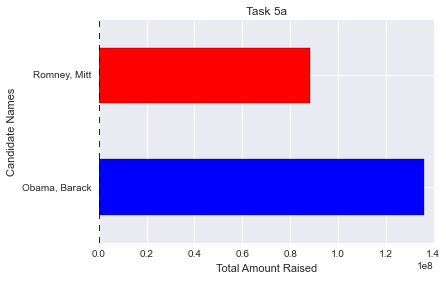

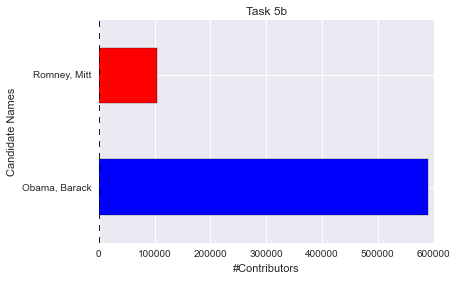

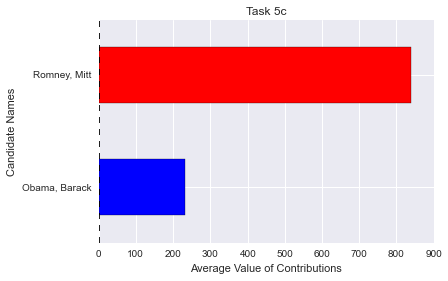

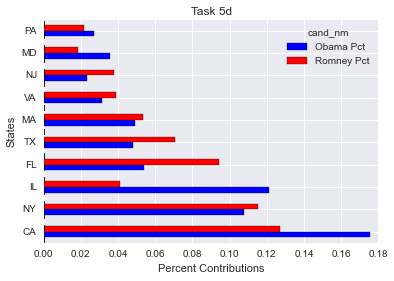

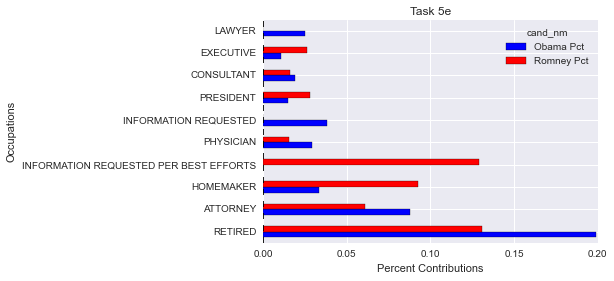

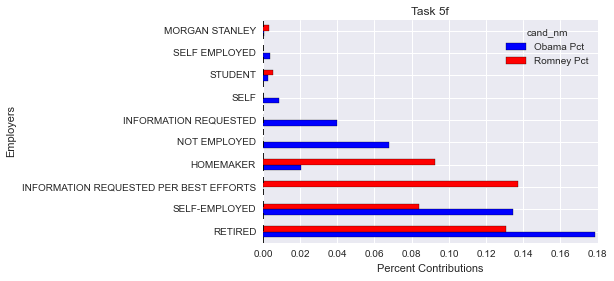

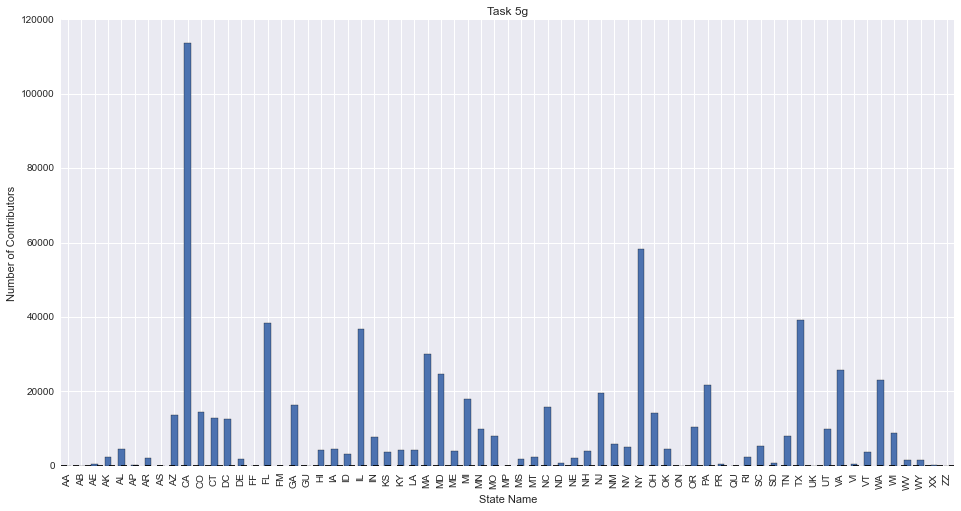

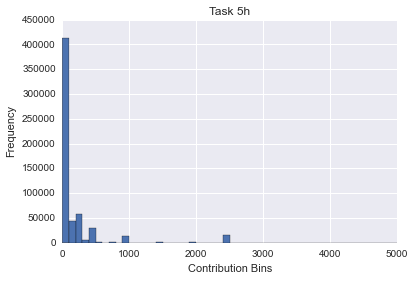

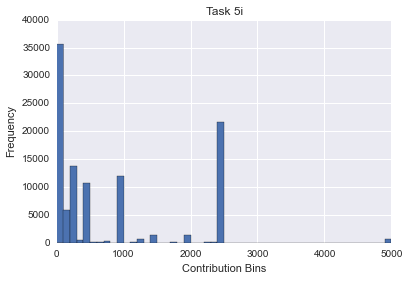

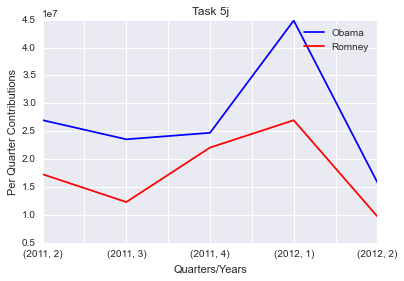

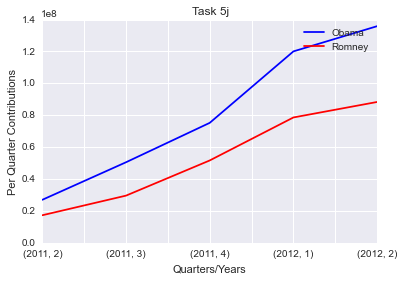

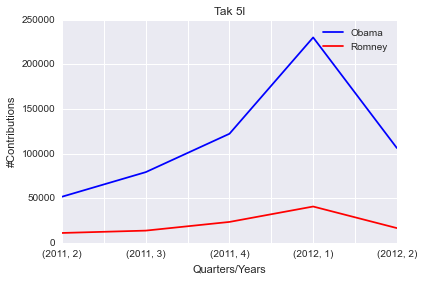

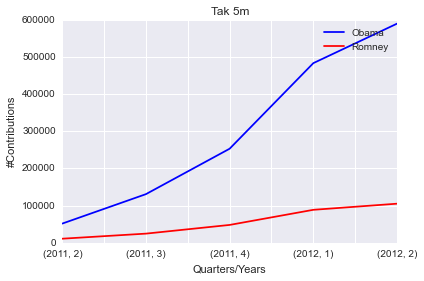

In [30]:
#Task 5a: Draw a "horizontal" bar chart with one bar each for Obama and Romney with the value corresponding to total amount they raised.
# Remember to make the bar chart into a horizontal bar chart
#########################begin code for Task 5a
plt.figure()
figObj5a = fec.contb_receipt_amt.groupby(fec.cand_nm).sum().plot(kind='barh', title='Task 5a',color=['blue','red'])
figObj5a.set_xlabel('Total Amount Raised')
figObj5a.set_ylabel('Candidate Names')
#########################end code for Task 5a


#Task 5b: Draw the "horizontal" bar chart of total NUMBER of contributions made per Candidate.
# ie Candidate name vs number of contributions for that candidate
#########################begin code for Task 5b
plt.figure()
figObj5b = fec.contbr_nm.groupby(fec.cand_nm).agg('count').plot(kind='barh', title='Task 5b',color=['blue','red'])
figObj5b.set_xlabel('#Contributors')
figObj5b.set_ylabel('Candidate Names')
#########################end code for Task 5b

#Task 5c: Draw the "horizontal" bar chart of average contributions made per Candidate.
# ie Candidate Name vs avg contribution
#########################begin code for Task 5c
plt.figure()
figObj5c = fec.contb_receipt_amt.groupby(fec.cand_nm).mean().plot(kind='barh',title='Task 5c',color=['blue','red'])
figObj5c.set_xlabel('Average Value of Contributions')
figObj5c.set_ylabel('Candidate Names') 
#########################end code for Task 5c


#Task 5d: Draw a "horizontal" bar chart that lists the top-10 states based on the TOTAL contribution they made to both candidates
# For each state, draw two lines - one in blue for Obama and one in red for Romney
# Display the proportion of the total contribution that came from the state.
# For eg, if Obama made 1 billion and TX gave 100 million of it, the proportion is 10% 
# Remember to make the bar chart into a horizontal bar chart
#########################begin code for Task 5d
plt.figure()
t5dTotalContrib = fec.groupby(['cand_nm', 'contbr_st']).contb_receipt_amt.sum().unstack(0).fillna(0)
t5dTotalContrib['Total'] = t5dTotalContrib['Obama, Barack'] + t5dTotalContrib['Romney, Mitt']
t5dPercentContrib = t5dTotalContrib / t5dTotalContrib.sum(axis=0)
t5dTotalContrib['Obama Pct'],  t5dTotalContrib['Romney Pct'] = t5dPercentContrib['Obama, Barack'], t5dPercentContrib['Romney, Mitt']
t5dTop10States = t5dTotalContrib.sort('Total', ascending=False)[:10]
figObj5d = t5dTop10States[['Obama Pct', 'Romney Pct']].plot(kind='barh', title='Task 5d', color=['blue','red'])
figObj5d.set_xlabel('Percent Contributions')
figObj5d.set_ylabel('States') 
#########################end code for Task 5d


#Task 5e: Now repeat the same process based on Occupation (again top-10)
#########################begin code for Task 5e
plt.figure()
t5eTotalContrib = fec.groupby(['cand_nm', 'contbr_occupation']).contb_receipt_amt.sum().unstack(0).fillna(0)
t5eTotalContrib['Total'] = t5eTotalContrib['Obama, Barack'] + t5eTotalContrib['Romney, Mitt']
t5ePercentContrib = t5eTotalContrib / t5eTotalContrib.sum(axis=0)
t5eTotalContrib['Obama Pct'],  t5eTotalContrib['Romney Pct'] = t5ePercentContrib['Obama, Barack'], t5ePercentContrib['Romney, Mitt']
t5eTop10Occuation = t5eTotalContrib.sort('Total', ascending=False)[:10]
figObj5e = t5eTop10Occuation[['Obama Pct', 'Romney Pct']].plot(kind='barh', title='Task 5e', color=['blue','red'])
figObj5e.set_xlabel('Percent Contributions')
figObj5e.set_ylabel('Occupations') 
#########################end code for Task 5e


#Task 5f: Now repeat the same process based on Employers (again top-10)
#########################begin code for Task 5f
plt.figure()
t5fTotalContrib = fec.groupby(['cand_nm', 'contbr_employer']).contb_receipt_amt.sum().unstack(0).fillna(0)
t5fTotalContrib['Total'] = t5fTotalContrib['Obama, Barack'] + t5fTotalContrib['Romney, Mitt']
t5fPercentContrib = t5fTotalContrib / t5fTotalContrib.sum(axis=0)
t5fTotalContrib['Obama Pct'],  t5fTotalContrib['Romney Pct'] = t5fPercentContrib['Obama, Barack'], t5fPercentContrib['Romney, Mitt']
t5fTop10Employers = t5fTotalContrib.sort('Total', ascending=False)[:10]
figObj5f = t5fTop10Employers[['Obama Pct', 'Romney Pct']].plot(kind='barh', title='Task 5f', color=['blue','red'])
figObj5f.set_xlabel('Percent Contributions')
figObj5f.set_ylabel('Employers')
#########################end code for Task 5f


#Task 5g: Draw the histogram of total NUMBER of contributions made per each state.
# X-axis : state, Y-axis : number of contribution from that state
#########################begin code for Task 5g
plt.figure(figsize=(16, 8)) 
figObj5g = fec.contbr_nm.groupby(fec.contbr_st).count().plot(kind = 'bar',title='Task 5g')
figObj5g.set_xlabel('State Name')
figObj5g.set_ylabel('Number of Contributors')
#########################end code for Task 5g


#Task 5h: Draw a histogram of actual contributions made for Obama. Set bin size as 50
#X-axis: contribution amount bin, Y-axis: frequency
#########################begin code for Task 5h

#####Note: Hist by default, tries to create bins that are neatly arranged from min to max. 
# However, the contribution amounts are very skewed. 
# If you run the command fec.contb_receipt_amt.describe() you can see that 75% of them are below 250 but max value is 2014490.51
# Hence default hist will not work here as most people gave small amount
# For eg, only 10 contributions to Obama was above $5000 (you can verify by the line below)
# len(fec.contb_receipt_amt[(fec.cand_nm == 'Obama, Barack') & (fec.contb_receipt_amt > 5000)])
#There are many ways to fix it - including cut and qcut of pandas.
# I am going for a simple solution - which is to ignore the top-10 contributions (above 5000)
# and plt only the rest
plt.figure()
figObj5h = fec.contb_receipt_amt[(fec.cand_nm == 'Obama, Barack') & (fec.contb_receipt_amt <= 5000)].hist(bins = 50)
figObj5h.set_xlabel('Contribution Bins')
figObj5h.set_ylabel('Frequency')
figObj5h.set_title('Task 5h')
#########################end code for Task 5h


#Task 5i: Draw a histogram of actual contributions made for Romney. Set bin size as 50
#X-axis: contribution amount bin, Y-axis: frequency
#########################begin code for Task 5i
plt.figure()
figObj5i = fec.contb_receipt_amt[(fec.cand_nm == 'Romney, Mitt') & (fec.contb_receipt_amt <= 5000)].hist(bins = 50)
figObj5i.set_xlabel('Contribution Bins')
figObj5i.set_ylabel('Frequency')
figObj5i.set_title('Task 5i')

#########################end code for Task 5i


#Harder
#Task 5j: Draw a line chart showing how the campaign contribution of Obama and Romney varied every quarter
#Use blue for Obama and red for Romney
#This is a bit tricky because, you have to convert contribution date to quarter.
#You can either do it on your own or see if Pandas has some function
#########################begin code for Task 5j

#Ignore the warning 
plt.figure()
t5jContbDateTime = pd.to_datetime(fec.contb_receipt_dt)
fec.loc[:,'contb_receipt_dt_quarter'] = map(lambda dateTime: dateTime.quarter, t5jContbDateTime)
fec.loc[:,'contb_receipt_dt_year'] = map(lambda dateTime: dateTime.year, t5jContbDateTime)
figObj5j = fec['contb_receipt_amt'][fec.cand_nm=='Obama, Barack'].groupby(
                [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).sum().plot(color='Blue')
fec['contb_receipt_amt'][fec.cand_nm=='Romney, Mitt'].groupby(
                [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).sum().plot(color='Red')
figObj5j.set_title('Task 5j')
figObj5j.set_xlabel('Quarters/Years')
figObj5j.set_ylabel('Per Quarter Contributions')
figObj5j.legend (['Obama', 'Romney'])
#########################end code for Task 5j


#Harder
#Task 5k: Draw a line chart showing the CUMULATIVE campaign contribution of Obama and Romney varied every quarter
# In other words, if Obama made X, Y, Z in first, second and third quarters
#  then plot X for first quarter, X+Y for second quarter and X+Y+Z for third quarter.
#Use blue for Obama and red for Romney
#This is a bit tricky because, you have to convert contribution date to quarter.
#You can either do it on your own or see if Pandas has some function
#########################begin code for Task 5k
plt.figure()
figObj5k = fec['contb_receipt_amt'][fec.cand_nm=='Obama, Barack'].groupby(
                [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).sum().cumsum().plot(color='Blue')
fec['contb_receipt_amt'][fec.cand_nm=='Romney, Mitt'].groupby(
                [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).sum().cumsum().plot(color='Red')
figObj5k.set_title('Task 5j')
figObj5k.set_xlabel('Quarters/Years')
figObj5k.set_ylabel('Per Quarter Contributions')
figObj5k.legend (['Obama', 'Romney'])
#########################end code for Task 5k

#Tasks 5l and 5m
#Repeat 5j and 5k but do it for NUMBER of contributors
#In other words, 5l plots the number of contributors for Obama and Romney, quarter over quarter
#5m plots cumulative number of contributors quarter over quarter.

#########################begin code for Task 5l
plt.figure()
figObj5l = fec['contb_receipt_amt'][fec.cand_nm=='Obama, Barack'].groupby(
                        [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).count().plot(color='Blue')
fec['contb_receipt_amt'][fec.cand_nm=='Romney, Mitt'].groupby(
                        [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).count().plot(color='Red')
figObj5l.set_title('Tak 5l')
figObj5l.set_xlabel('Quarters/Years')
figObj5l.set_ylabel('#Contributions')
figObj5l.legend (('Obama', 'Romney'))
#########################end code for Task 5l


#########################begin code for Task 5m
plt.figure()
figObj5m = fec['contb_receipt_amt'][fec.cand_nm=='Obama, Barack'].groupby(
                        [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).count().cumsum().plot(color='Blue')
fec['contb_receipt_amt'][fec.cand_nm=='Romney, Mitt'].groupby(
                        [fec.contb_receipt_dt_year,fec.contb_receipt_dt_quarter]).count().cumsum().plot(color='Red')
figObj5m.set_title('Tak 5m')
figObj5m.set_xlabel('Quarters/Years')
figObj5m.set_ylabel('#Contributions')
figObj5m.legend (('Obama', 'Romney'))
#########################end code for Task 5m


Task 6: Discretization
-----------------------

Recall the IMDB dataset that we discussed in the class where we were able to draw lot more interesting plots. The key challenge here is that most of the attributes have too many values (ie. the domain cardinality is very large). There are few ways to work around this issue. We already did something above (ie focussing only top-k). The other option is **discretization** where we create buckets and put contributions based on the buckets. Discretization in Pandas is acheived  by cut function.

Task 6a:
cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                         493            77
(1, 10]                      40070          3681
(10, 100]                   372280         31853
(100, 1000]                 153991         43357
(1000, 10000]                22284         26186
(10000, 100000]                  2             1
(100000, 1000000]                3           NaN
(1000000, 10000000]              4           NaN


Task 6b:
cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                      318.24         77.00
(1, 10]                  337267.62      29819.66
(10, 100]              20288981.41    1987783.76
(100, 1000]            54798531.46   22363381.69
(1000, 10000]          51753705.67   63942145.42
(10000, 100000]           59100.00      12700.00
(100000, 1000000]       1490683.08           NaN
(1000000, 10000000]     7148839.76           NaN


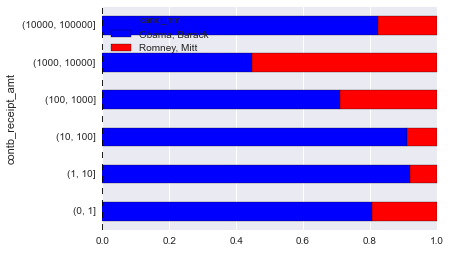

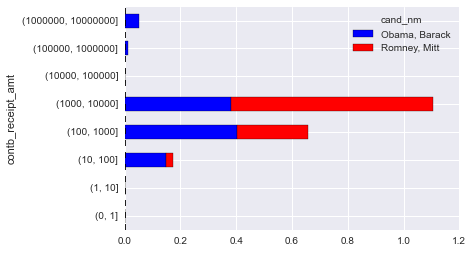

In [31]:
#The following set of tasks are a bit tricky: 
#    you need to use multiple commands to achieve. Specifically look at cut, groupby and unstack

#Task 6a: Discretize the contributions of Obama and Romney based on the bins given below.
# For example, if Obama got contributions such as 2, 6, 16, 18, 120, then he has 
#  0 contribution in (0,1], 2 contributions in (1,10], 2 contributions in (10, 100] and 1 contribution in (100, 1000]
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec.contb_receipt_amt, bins) # set the variable labels to the output of pd.cut
grouped = fec.groupby(['cand_nm', labels]) #Group the data based on labels and candidate names
#Replace None below in the print statement with grouped.size().unstack(0) . 
#    If your code for labels and grouped is correct, this should print number of people in each bin per candidate
print "Task 6a:\n", grouped.size().unstack(0)

#Task 6b: In Task 6a, we calculated the COUNT (i.e. the number of contributors in each bin)
# This by itself is not sufficient.
# In this task, let us compute the TOTAL AMOUNT in each bucket.
# Specifically, compute for each candidate the total amount of contributions that each got in each bucket.
# Continuing the example above, Obama's total contribution in each bucket is
#  0 in (0,1], 8 in (1,10], 34 in (10, 100] and 120 in (100, 1000]
#This could be done in 1 line from the variable grouped above
t6b_bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
print "\n\nTask 6b:\n", t6b_bucket_sums


#Task 6c: Even this does not fully specify the disparity in the funding scenario.
# To see this let us now compute the PROPORTION of total contribution in each bucket
# This is called normalization and is a common operation. 
# Typically normalization is done over the same candidate.
# But for the point I am trying to make, let us normalize within bucket.
# For example, if obama made X in a bucket and Y in another bucket, 
#    then normalization will give X/(X+Y) for Obama and Y/(X+Y) for Romney
# This is also quite easy in Pandas and can be done in 1 line
# The key idea is to realize that sum function takes an argument called axis
#  that does different things for axis=0 and axis=1 (figure out which does what)
t6c_normed_bucket_sums = t6b_bucket_sums.div(t6b_bucket_sums.sum(axis=1), axis=0)
print "\n\nTask 6c:\n", t6c_normed_bucket_sums

#Once you have done this , uncomment the following line to a horizontal stacked bar chart
t6c_normed_bucket_sums[:-2].plot(kind='barh', stacked=True, color=['blue','red'])


#Task 6d: Let us go back and try to do the other analysis
# Let us now try to see what PROPORTION of each candidate's amount came from each bucket.
#  This is the classical case of normalization.
#  Continuing the example above, Obama has made 0+8+34+120=162
#  We can normalize it by diving each bucket by the total
#   For example, 0/162, 8/162, 34/162 and 120/162.
#  If you finished t6c, then this just a matter of playing with axis values.
t6d_normed_bucket_sums = t6b_bucket_sums.div(t6b_bucket_sums.sum(axis=0),axis=1)
print "\n\nTask 6d:\n", t6d_normed_bucket_sums


#Once you have done this , uncomment the following line to a horizontal stacked bar chart
t6d_normed_bucket_sums.plot(kind='barh', stacked=True,color=['blue','red'])




Task 7: Big Money in Politics
------------------------------

Using the tool of discretization, we were able to analyze how much people contributed in each bucket. While it showed some sense of imbalance, it did not show it clearly. Recently, the concept of income inequality is becoming a rallying cry among liberals. Let us see if there is any inequality in the contributions (spoiler alert: yes!). We can see if we find anything interesting, not by analyzing, total amount but by the amount contributed by top-X%.



In [32]:
#Task 7a: Write two functions: one for Obama and one for Romney that does the following:
# Given a value of N (N can be 1, 2, 5, 10 etc), sort the contributions made to the candidate in decreasing order
#  Then find how much contribution the top-N% made
#  Then compute the fraction to the overall campaign collection
# For example, if Obama collected 1 billion dollars and the top-1% gave 100 million then their contribution is 10%

def t7a_helper_contributions_by_top_N_pct(candidate_name, N):
    pivotTblUniqContr = pd.tools.pivot.pivot_table(fec[fec.cand_nm == candidate_name], 
                        values='contb_receipt_amt', 
                        index=['contbr_nm', 'contbr_occupation', 'contbr_employer', 'contbr_zip', 'contbr_city','contbr_st'], 
                        aggfunc=np.sum).order(ascending=False)
    totalContrib = pivotTblUniqContr.sum()
    numContrib = pivotTblUniqContr.count()
    percent = int(N/100.0 *  numContrib)
    topNContrib = pivotTblUniqContr.iloc[:percent].sum()
    
    return topNContrib/totalContrib


def t7a_contributions_by_top_N_pct_obama(N):
    return t7a_helper_contributions_by_top_N_pct('Obama, Barack', N)
    
def t7a_contributions_by_top_N_pct_romney(N):
    return t7a_helper_contributions_by_top_N_pct('Romney, Mitt', N)


for N in [1, 2, 5, 10, 20]:
    print "N=%s, Obama proportion=%s and Romney proportion = %s" % (N, 
                t7a_contributions_by_top_N_pct_obama(N), t7a_contributions_by_top_N_pct_romney(N))

    

#Task 7b: Now let us see who these people in 1% are
# Compute the top-1% based on total contribution (ie. money they gave to Obama + Romney)
# Now let us see some information about them.
# For each of the folks in 1%, print the following:
#    name, state, occupation, employer, total amount they gave to Obama, total amount they gave to Romney
contributors_and_contrib = fec.pivot_table(values= 'contb_receipt_amt', 
                        index= ['contbr_nm', 'contbr_occupation', 'contbr_employer', 'contbr_city', 'contbr_st'],
                        columns='cand_nm', aggfunc=np.sum, fill_value=0)
num1Percenters = int(0.01 * len(contributors_and_contrib))
contributors_and_contrib["Total"] = contributors_and_contrib["Obama, Barack"] + contributors_and_contrib["Romney, Mitt"]
contributors_ordered_by_contrib = contributors_and_contrib.sort(["Total"], ascending = False)
t7b_1pcters = contributors_ordered_by_contrib.iloc[:num1Percenters]

display(contributors_ordered_by_contrib)

N=1, Obama proportion=0.150775678905 and Romney proportion = 0.0463774533432
N=2, Obama proportion=0.233644483744 and Romney proportion = 0.078658416654
N=5, Obama proportion=0.424594528848 and Romney proportion = 0.138822888029
N=10, Obama proportion=0.5666857722 and Romney proportion = 0.2390652498
N=20, Obama proportion=0.709150146108 and Romney proportion = 0.439549973343


cand_nm                                                                                                                                        Obama, Barack  \
contbr_nm                            contbr_occupation                      contbr_employer                        contbr_city      contbr_st                  
OBAMA VICTORY FUND 2012 - UNITEMIZED ZOOLOGY EDUCATION                      ]                                      CHICAGO          IL            8187796.84   
                                                                                                                   WASHINGTON       DC             451726.00   
MURPHY, CYNTHIA C.                   PUBLIC RELATIONS                       MURPHY GROUP                           LITTLE ROCK      AR              35800.00   
DAVIS, STEPHEN JAMES                 ATTORNEY                               BANNEKER PARTNERS                      SAN FRANCISCO    CA              30800.00   
BOULIND, JEANNETTE                   NOT EMPLOYED                           NOT EMPLOYED                           PHILADELPHIA     PA              20000.00   
HIEMSTRA, SHERRON                    RETIRED                                RETIRED                                WASHINGTON       DC              20000.00   
PEROT, FRANCIS KINCAID               CONSULTANT                             SELF-EMPLOYED                          WARREN           VT              20000.00   
KLEIN, PATRICIA                      RETIRED                                RETIRED                                ZIONSVILLE       PA              17750.00   
MEDORE, MARK                         INVESTOR                               SELF-EMPLOYED                          OAKLAND PARK     FL              15195.00   
ABRAMS, EDWIN                        RETIRED                                RETIRED                                VERO BEACH       FL              15000.00   
ANDERSON, SALLY                      ADMINISTRATOR                          ROSWELL ARTIST IN RESIDENCE FOUNDATION ROSWELL          NM              15000.00   
TRAUB, JANET E.                      NOT EMPLOYED                           NOT EMPLOYED                           SAN FRANCISCO    CA              15000.00   
ROLFE, RONALD                        LAWYER                                 SELF-EMPLOYED                          NEW YORK         NY              15000.00   
BISHOP, ROBERT C.                    RETIRED                                RETIRED                                REDWOOD CITY     CA              15000.00   
STEINBRING, YVONNE                   RETIRED                                RETIRED                                GREEN VALLEY     AZ              15000.00   
COHN, NANCY                          VOLUNTEER                              VOLUNTEER                              TALLAHASSEE      FL              15000.00   
ANSTROM, DECKER                      RETIRED                                RETIRED                                WASHINGTON       DC              15000.00   
DENNE, CONSTANCE AYERS               RETIRED                                RETIRED                                GREENPORT        NY              15000.00   
LANDIS, HOWARD KEL                   FINANCIAL SERVICES                     PLEXUS CAPITAL                         RALEIGH          NC              15000.00   
WEST, RUTH ANN                       INVESTOR                               SELF-EMPLOYED                          DURANGO          CO              15000.00   
FRANKLIN, VIRGINIA                   RETIRED                                RETIRED                                TULSA            OK              14000.00   
CARY, LAURA                          RETIRED                                RETIRED                                DENVER           CO              13000.00   
WEISSLER, STUART C.                  RETIRED                                RETIRED                                COCONUT CREEK    FL              13000.00   


Task 8: Political Polarization in USA
------------------------------------------

It has been argued that political polarization has dramatically increased in USA in the last 10-15 years. While there are many ways to analyze the dataset for polarization, let us use some simple measures.

In [33]:
#Task 8a: One way to measure polarity is to see how different some distribution are. 
# For both Obama and Romney, print the top-10 states based on their total AMOUNT of contribution
# Do you see lot of common states? 
t8a_top_10_states_obama = fec.contb_receipt_amt[fec.cand_nm == 'Obama, Barack'].groupby(fec.contbr_st).sum().order(ascending=False)[:10]
t8a_top_10_states_romney = fec.contb_receipt_amt[fec.cand_nm == 'Romney, Mitt'].groupby(fec.contbr_st).sum().order(ascending=False)[:10]

print "\n\nT8a: Top 10 states for Obama:\n",t8a_top_10_states_obama
print "\n\nT8a: Top 10 states for Romney:\n",t8a_top_10_states_romney

#Task 8b: For both Obama and Romney, print the top-10 occupation based on their total AMOUNT of contribution
# Do you see lot of common occupation? 
t8b_top_10_occu_obama = fec['contb_receipt_amt'][fec.cand_nm == 'Obama, Barack'].groupby(fec.contbr_occupation).sum().order(ascending=False)[:10]
t8b_top_10_occu_romney = fec['contb_receipt_amt'][fec.cand_nm == 'Romney, Mitt'].groupby(fec.contbr_occupation).sum().order(ascending=False)[:10]

print "\n\nT8b: Top 10 Occupation for Obama:\n", t8b_top_10_occu_obama
print "\n\nT8b: Top 10 Occupation for Romney:\n", t8b_top_10_occu_romney



#Task 8c: For both Obama and Romney, print the top-10 employers based on their total AMOUNT of contribution
# Do you see lot of common employers? 
t8c_top_10_emp_obama = fec['contb_receipt_amt'][fec.cand_nm == 'Obama, Barack'].groupby(fec.contbr_employer).sum().order(ascending=False)[:10]
t8c_top_10_emp_romney = fec['contb_receipt_amt'][fec.cand_nm == 'Romney, Mitt'].groupby(fec.contbr_employer).sum().order(ascending=False)[:10]

print "\n\nT8b: Top 10 Employers for Obama:\n", t8c_top_10_emp_obama
print "\n\nT8b: Top 10 Employers for Romney:\n", t8c_top_10_emp_romney


#Harder
#Task 8d: Here is another way to compute polarization
# Find the top-1000 contributors based on their TOTAL contribution (to both Obama and Romney)
# For each of the top-1000 folks count the number of people who donated to both, to Obama only and to Romney only
top1000Contributors = fec.pivot_table(values='contb_receipt_amt',
                                      index=['contbr_nm','contbr_employer','contbr_st','cand_nm'],
                                      aggfunc = np.sum).order(ascending = False).head(1000).unstack().fillna(0)
t8d_top_1000_both = len(top1000Contributors[ (top1000Contributors["Obama, Barack"] > 0) & (top1000Contributors["Romney, Mitt"] > 0)])
t8d_top_1000_BO_only = len(top1000Contributors[ (top1000Contributors["Obama, Barack"] > 0) & (top1000Contributors["Romney, Mitt"] == 0)])
t8d_top_1000_MR_only = len(top1000Contributors[ (top1000Contributors["Obama, Barack"] == 0) & (top1000Contributors["Romney, Mitt"] > 0)])

print "\n\nT8c:Both, Obama only, Romney only = ", t8d_top_1000_both, t8d_top_1000_BO_only, t8d_top_1000_MR_only

#Harder:
#Task 8e: Here is yet another way
# For each state, compute what fraction of amount went to Obama and what fraction went to Romney
# If there is no polarization, then both will get more or less equal amount. 
# If there is polarization, then the amount will skewed.
# Let us use a very crude measure to compute polarization
#    If X is what Obama got from a state and Y is what Romney got, compute the value of max(X,Y)/ (min(X,Y) + 1)
# For each state compute this value and sort the results in a descending order. 
# Do you see any pattern?
t8e = fec.pivot_table(values = 'contb_receipt_amt', index = ['contbr_st'], columns = ['cand_nm'],  aggfunc = np.sum, fill_value=0)
t8e["polarity"] = t8e.apply(
                        lambda row: max(row["Obama, Barack"], row["Romney, Mitt"])  / (min(row["Obama, Barack"], row["Romney, Mitt"])+1), 
                        axis=1)
t8e_state_contr_ranked_by_polarity = t8e.sort(["polarity"], ascending=False)
print "\n\nt8e:States ordered by polarity \n", t8e_state_contr_ranked_by_polarity


#Harder:
#Task 8f: Repeat the above analysis for occupation
# However, instead of taking all occupations, let us only take the top-50 occupations based on TOTAL contributions made
# For each occupation compute this value and sort the results in a descending order and displ
# Do you see any pattern?
t8f = fec.pivot_table(values = 'contb_receipt_amt', index = ['contbr_occupation'], columns = ['cand_nm'],  aggfunc = np.sum, fill_value=0)
t8f['Total'] = t8f['Obama, Barack'] + t8f['Romney, Mitt']
t8f = t8f.sort(['Total'], ascending=False)[:50]
t8f["polarity"] = t8f.apply(
                        lambda row: max(row["Obama, Barack"], row["Romney, Mitt"])  / (min(row["Obama, Barack"], row["Romney, Mitt"])+1), 
                        axis=1)
t8f_occu_contr_ranked_by_polarity = t8f.sort(["polarity"], ascending=False)
print "\n\nt8f: Occupation ordered by polarity:\n", t8f_occu_contr_ranked_by_polarity


#Harder:
#Task 8g: A known variable of polarization is based on where a person lives.
# At the risk of too much generalization, liberals dominate cities while conservations dominate rural areas
# Let us see if this holds in Texas.
# Texas is a known solid red (i.e. conservative) state.
# For each city in Texas, compute the polarity and order them by polarity.
# Do you see any pattern?
t8g = fec[fec.contbr_st == 'TX'].pivot_table(values = 'contb_receipt_amt', 
                                            index = ['contbr_city'], columns=['cand_nm'], aggfunc=np.sum, fill_value=0)
t8g['Total'] = t8g['Obama, Barack'] + t8g['Romney, Mitt']	
t8g["polarity"] = t8g.apply(
                        lambda row: max(row["Obama, Barack"], row["Romney, Mitt"])  / (min(row["Obama, Barack"], row["Romney, Mitt"])+1), 
                        axis=1)
t8g_tx_city_contr_ranked_by_polarity = t8g.sort(['polarity'], ascending=False)
print "\n\nt8f: Texas cities ordered by polarity:\n", t8g_tx_city_contr_ranked_by_polarity




T8a: Top 10 states for Obama:
contbr_st
CA           23824984.24
IL           16443895.84
NY           14651918.51
FL            7318178.58
MA            6649015.25
TX            6570832.45
MD            4832663.93
DC            4373538.80
VA            4259977.19
WA            4250933.16
Name: contb_receipt_amt, dtype: float64


T8a: Top 10 states for Romney:
contbr_st
CA           11237636.60
NY           10184212.63
FL            8338458.81
TX            6221989.68
MA            4710542.30
UT            3717300.48
IL            3628571.53
CT            3499475.45
VA            3465765.85
NJ            3333320.20
Name: contb_receipt_amt, dtype: float64


T8b: Top 10 Occupation for Obama:
contbr_occupation
RETIRED                  25305116.38
ATTORNEY                 11141982.97
INFORMATION REQUESTED     4866973.96
HOMEMAKER                 4248875.80
PHYSICIAN                 3735124.94
LAWYER                    3160478.87
CONSULTANT                2459912.71
PROFESSOR             